In [171]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [172]:
links = pd.read_csv('../netology-recsys/lecture-1/links.csv')
movies = pd.read_csv('../netology-recsys/lecture-1/movies.csv')
ratings = pd.read_csv('../netology-recsys/lecture-1/ratings.csv')
tags = pd.read_csv('../netology-recsys/lecture-1/tags.csv')

Задача:
    - порекомендовать пользователю фильмы, которые он не смотрел, на основе жанров и тегов фильмов, которые он смотрел
    - предсказать оценки, которые пользователь может поставить рекомендованным ему фильмам

In [173]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [174]:
movies.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


In [175]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [185]:
#сколько оценок каждого ранга
ratings["rating"].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [199]:
#сколько оценок каждого ранга поставил пользователь
ratings.groupby('userId').rating.value_counts()

userId  rating
1       5.0       124
        4.0        76
        3.0        26
        2.0         5
        1.0         1
2       4.0         9
        5.0         6
        3.0         4
        3.5         4
        4.5         4
        2.0         1
        2.5         1
3       0.5        20
        5.0        10
        4.5         5
        2.0         1
        3.0         1
        3.5         1
        4.0         1
4       4.0        64
        5.0        64
        3.0        39
        2.0        26
        1.0        23
5       3.0        17
        4.0        13
        5.0        10
        2.0         3
        1.0         1
6       3.0       152
                 ... 
606     1.5        13
        1.0         6
        0.5         4
607     3.0        63
        4.0        59
        5.0        52
        2.0        10
        1.0         3
608     3.0       169
        4.0       162
        3.5       126
        2.5        95
        4.5        95
        2.0      

In [177]:
# соединим таблицу с рейтингами и названиями фильмов
movies_joined_ratings = ratings.join(movies.set_index('movieId'), on='movieId')

In [178]:
movies_joined_ratings.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


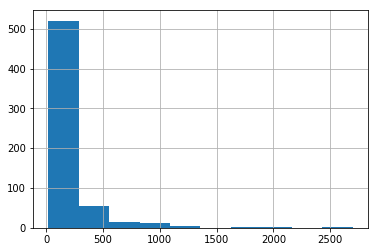

In [180]:
# гистограмма по количеству оценок на фильм
movies_joined_ratings.groupby('userId').rating.count().hist()

In [73]:
# функция заменяет различные разделители текста пробелами
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [74]:
# видоизменяем описание жанров для удобства
movie_genres = [change_string(g) for g in movies.genres.values]

In [75]:
movie_genres[:10]

['Adventure Animation Children Comedy Fantasy',
 'Adventure Children Fantasy',
 'Comedy Romance',
 'Comedy Drama Romance',
 'Comedy',
 'Action Crime Thriller',
 'Comedy Romance',
 'Adventure Children',
 'Action',
 'Action Adventure Thriller']

In [76]:
#создаём векторы для каждого типа жанров
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres) #считаем количество встречаемости каждого жанра

In [77]:
#считаем коэффициенты частотности встречаемых жанров
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [78]:
#определяем 7 ближайших соседей
neigh = NearestNeighbors(n_neighbors=7, n_jobs=-1, metric='euclidean') 
neigh.fit(X_train_tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=-1, n_neighbors=7, p=2, radius=1.0)

In [79]:
test = change_string("Adventure|Comedy|Fantasy|Crime")

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [80]:
res

(array([[0.42079615, 0.53300564, 0.54288608, 0.54288608, 0.54288608,
         0.54288608, 0.54288608]]),
 array([[6774, 9096, 5636, 6723, 3376, 7496, 9717]]))

In [81]:
movies.iloc[res[1][0]]

,movieId,title,genres
6774,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy
9096,143559,L.A. Slasher (2015),Comedy|Crime|Fantasy
5636,27368,Asterix & Obelix: Mission Cleopatra (Astérix &...,Adventure|Comedy|Fantasy
6723,58972,Nim's Island (2008),Adventure|Comedy|Fantasy
3376,4591,Erik the Viking (1989),Adventure|Comedy|Fantasy
7496,82854,Gulliver's Travels (2010),Adventure|Comedy|Fantasy
9717,188833,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy


In [138]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [139]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [140]:
movies_with_tags = movies.join(tags.set_index('movieId'), on='movieId')

In [151]:
movies_with_tags.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


In [152]:
movies_with_tags[movies_with_tags.title == 'Toy Story (1995)']

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09


In [153]:
movies_with_tags.tag.unique()

array(['pixar', 'fun', 'fantasy', ..., 'star wars', 'gintama', 'remaster'],
      dtype=object)

In [156]:
movies_with_tags.dropna(inplace=True)

In [157]:
movies_with_tags.title.unique().shape

(1572,)

In [145]:
tag_strings = []
movies = []

for movie, group in tqdm_notebook(movies_with_tags.groupby('title')):
    tag_strings.append(' '.join([str(s).replace(' ', '').replace('-', '') for s in group.tag.values]))
    movies.append(movie)

In [146]:
len(tag_strings)

1572

In [107]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(tag_strings)

In [108]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [109]:
neigh = NearestNeighbors(n_neighbors=10, n_jobs=-1, metric='manhattan') 
neigh.fit(X_train_tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
         metric_params=None, n_jobs=-1, n_neighbors=10, p=2, radius=1.0)

In [110]:
for i in range(len(movies)):
    if 'Shattered Glass (2003)' == movies[i]:
        print(i)

1227


In [112]:
tag_strings[1227]

'journalism'

In [113]:
test = change_string('journalism')

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [114]:
res

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]),
 array([[ 860, 1227, 1016, 1420,  950, 1466,  288,  202,  661,  822]]))

In [115]:
for i in res[1][0]:
    print(movies[i])

Meet John Doe (1941)
Shattered Glass (2003)
Paper, The (1994)
To Die For (1995)
Network (1976)
Up Close and Personal (1996)
Control Room (2004)
Broadcast News (1987)
In a Lonely Place (1950)
Magnolia (1999)


In [160]:
movies_with_tags.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


In [161]:
movies_with_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 0 to 9732
Data columns (total 6 columns):
movieId      3683 non-null int64
title        3683 non-null object
genres       3683 non-null object
userId       3683 non-null float64
tag          3683 non-null object
timestamp    3683 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 201.4+ KB


In [159]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
